In [1]:
import pandas as pd
import shap 

In [2]:
# import dask 
from dask.distributed import Client, progress
client = Client(processes=False, threads_per_worker=4,
                n_workers=1, memory_limit='2GB')
client

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41873 instead


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://10.0.80.197:41873/status,
Dashboard: http://10.0.80.197:41873/status,Workers: 1
Total threads: 4,Total memory: 1.86 GiB
Status: running,Using processes: False
Comm: inproc://10.0.80.197/1937/1,Workers: 1
Dashboard: http://10.0.80.197:41873/status,Total threads: 4
Started: Just now,Total memory: 1.86 GiB
Comm: inproc://10.0.80.197/1937/4,Total threads: 4
Dashboard: http://10.0.80.197:35265/status,Memory: 1.86 GiB
Nanny: None,


In [3]:
data = pd.read_csv("votedmetadata_water.csv")

data

,sample_id,Cl_mgL,Dam.Upstream.Site,del18O_permil,del2H_permil,F_mgL,General_Vegetation,Hydrogeomorphology,Intermittent_or_Perennial,03_mgL,...,Precipitation.Within.Week,Primary.Sources.Flow.Variation,Sediment,SO4_mgL,Stream_Order,Temp_degC,altS,MAT,MAP,cluster
0,SW_S19S.0003_U_1,0.30,1.0,-18.75,-140.0,0.07,15,2,1,0.19,...,1.0,12,3,9.80,7.0,17.0,347.0,8.7,299.0,sw_2
1,SW_S19S.0003_U_2,0.31,1.0,NaN,NaN,0.07,15,2,1,0.23,...,1.0,12,3,8.03,7.0,17.0,347.0,8.7,299.0,sw_2
2,SW_S19S.0003_U_3,0.31,1.0,NaN,NaN,0.06,15,2,1,0.23,...,1.0,12,3,8.62,7.0,17.0,347.0,8.7,299.0,sw_0
3,SW_S19S.0004_U_1,1.83,1.0,-17.13,-129.3,0.07,7,2,1,0.12,...,1.0,12,1,6.53,6.0,18.0,346.0,7.7,449.0,sw_0
4,SW_S19S.0004_U_2,2.00,1.0,NaN,NaN,0.08,7,2,1,0.12,...,1.0,12,1,6.66,6.0,18.0,346.0,7.7,449.0,sw_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,SW_S19S.0099_U_1,70.55,1.0,-16.08,-122.8,0.33,2,1,0,4.43,...,0.0,9,1,47.79,7.0,27.3,160.0,11.8,1048.0,sw_0
261,SW_S19S.0099_U_2,68.35,1.0,NaN,NaN,0.29,2,1,0,4.64,...,0.0,9,1,45.59,7.0,27.3,160.0,11.8,1048.0,sw_0
262,SW_S19S.0099_U_3,66.16,1.0,NaN,NaN,0.30,2,1,0,4.75,...,0.0,9,1,44.37,7.0,27.3,160.0,11.8,1048.0,sw_0
263,SW_S19S.0100_U_1,0.22,1.0,-6.53,-43.3,0.09,17,1,1,0.12,...,1.0,5,1,34.62,2.0,14.2,2764.0,1.0,532.0,sw_1


In [4]:
# print all column titles 
data.columns

Index(['sample_id', 'Cl_mgL', 'Dam.Upstream.Site', 'del18O_permil',
       'del2H_permil', 'F_mgL', 'General_Vegetation', 'Hydrogeomorphology',
       'Intermittent_or_Perennial', '03_mgL', '02_mgL',
       'Number.Days.Since.Precip', 'pH', 'Precipitation.Within.Week',
       'Primary.Sources.Flow.Variation', 'Sediment', 'SO4_mgL', 'Stream_Order',
       'Temp_degC', 'altS', 'MAT', 'MAP', 'cluster'],
      dtype='object')

In [5]:
# check all the nans

print("No. of columns containing null values")
print(len(data.columns[data.isna().any()]))

print("No. of columns not containing null values")
print(len(data.columns[data.notna().all()]))

print("Total no. of columns in the dataframe")
print(len(data.columns))

No. of columns containing null values
15
No. of columns not containing null values
8
Total no. of columns in the dataframe
23


In [6]:
import numpy as np 
# drop the 'ID' column.

data2 = data[['Stream_Order', '03_mgL', 'Cl_mgL', 'Primary.Sources.Flow.Variation', 
              'Temp_degC', 'del18O_permil', 'SO4_mgL', 'MAP', 'Dam.Upstream.Site', 
              'MAT', 'F_mgL', 'Precipitation.Within.Week', 'altS', 'cluster']] #, 'Number.Days.Since.Precip'  -- extra 

data2

,Stream_Order,03_mgL,Cl_mgL,Primary.Sources.Flow.Variation,Temp_degC,del18O_permil,SO4_mgL,MAP,Dam.Upstream.Site,MAT,F_mgL,Precipitation.Within.Week,altS,cluster
0,7.0,0.19,0.30,12,17.0,-18.75,9.80,299.0,1.0,8.7,0.07,1.0,347.0,sw_2
1,7.0,0.23,0.31,12,17.0,NaN,8.03,299.0,1.0,8.7,0.07,1.0,347.0,sw_2
2,7.0,0.23,0.31,12,17.0,NaN,8.62,299.0,1.0,8.7,0.06,1.0,347.0,sw_0
3,6.0,0.12,1.83,12,18.0,-17.13,6.53,449.0,1.0,7.7,0.07,1.0,346.0,sw_0
4,6.0,0.12,2.00,12,18.0,NaN,6.66,449.0,1.0,7.7,0.08,1.0,346.0,sw_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,7.0,4.43,70.55,9,27.3,-16.08,47.79,1048.0,1.0,11.8,0.33,0.0,160.0,sw_0
261,7.0,4.64,68.35,9,27.3,NaN,45.59,1048.0,1.0,11.8,0.29,0.0,160.0,sw_0
262,7.0,4.75,66.16,9,27.3,NaN,44.37,1048.0,1.0,11.8,0.30,0.0,160.0,sw_0
263,2.0,0.12,0.22,5,14.2,-6.53,34.62,532.0,1.0,1.0,0.09,1.0,2764.0,sw_1


In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data2, test_size=0.20, random_state=42)
train # just display the train set for now. 

,Stream_Order,03_mgL,Cl_mgL,Primary.Sources.Flow.Variation,Temp_degC,del18O_permil,SO4_mgL,MAP,Dam.Upstream.Site,MAT,F_mgL,Precipitation.Within.Week,altS,cluster
172,5.0,0.12,4.28,6,22.1,NaN,10.91,1024.0,2.0,14.0,0.08,0.0,20.0,sw_0
232,3.0,0.12,10.80,9,11.5,NaN,80.07,640.0,1.0,7.7,0.12,0.0,1753.0,sw_1
18,6.0,0.12,6.96,5,25.6,-16.86,160.13,209.0,1.0,7.4,0.21,1.0,1504.0,sw_0
90,8.0,0.89,2.23,0,11.0,-17.24,12.11,184.0,2.0,12.0,0.11,0.0,112.0,sw_0
182,1.0,0.12,15.02,5,15.0,-5.86,10.24,1160.0,1.0,11.1,0.09,1.0,184.0,sw_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,7.0,0.85,7.44,5,30.0,-2.90,13.55,1255.0,1.0,19.2,0.11,1.0,18.0,sw_0
188,1.0,0.12,0.46,9,11.5,NaN,3.70,485.0,1.0,3.8,0.09,1.0,2535.0,sw_2
71,4.0,0.12,10.79,5,23.8,NaN,13.64,641.0,1.0,7.5,0.57,1.0,1788.0,sw_2
106,1.0,0.54,1719.10,17,29.1,0.72,209.18,1291.0,2.0,23.7,0.02,1.0,5.0,sw_0


In [8]:
# Drop the target column, that is the "cluster" column. 
# 1. Train data first. 
# Create X_train input and y_train for output (target) by dropping columns. 

X_train = train.drop(['cluster'], axis=1)

y_train = train["cluster"] 

X_train

,Stream_Order,03_mgL,Cl_mgL,Primary.Sources.Flow.Variation,Temp_degC,del18O_permil,SO4_mgL,MAP,Dam.Upstream.Site,MAT,F_mgL,Precipitation.Within.Week,altS
172,5.0,0.12,4.28,6,22.1,NaN,10.91,1024.0,2.0,14.0,0.08,0.0,20.0
232,3.0,0.12,10.80,9,11.5,NaN,80.07,640.0,1.0,7.7,0.12,0.0,1753.0
18,6.0,0.12,6.96,5,25.6,-16.86,160.13,209.0,1.0,7.4,0.21,1.0,1504.0
90,8.0,0.89,2.23,0,11.0,-17.24,12.11,184.0,2.0,12.0,0.11,0.0,112.0
182,1.0,0.12,15.02,5,15.0,-5.86,10.24,1160.0,1.0,11.1,0.09,1.0,184.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,7.0,0.85,7.44,5,30.0,-2.90,13.55,1255.0,1.0,19.2,0.11,1.0,18.0
188,1.0,0.12,0.46,9,11.5,NaN,3.70,485.0,1.0,3.8,0.09,1.0,2535.0
71,4.0,0.12,10.79,5,23.8,NaN,13.64,641.0,1.0,7.5,0.57,1.0,1788.0
106,1.0,0.54,1719.10,17,29.1,0.72,209.18,1291.0,2.0,23.7,0.02,1.0,5.0


In [9]:
y_train

172    sw_0
232    sw_1
18     sw_0
90     sw_0
182    sw_2
       ... 
20     sw_0
188    sw_2
71     sw_2
106    sw_0
102    sw_2
Name: cluster, Length: 212, dtype: object

In [10]:
# 2. Test dataset
X_test = test.drop(['cluster'], axis=1)

y_test = test["cluster"] 

X_test.head(10) # print only 10 

,Stream_Order,03_mgL,Cl_mgL,Primary.Sources.Flow.Variation,Temp_degC,del18O_permil,SO4_mgL,MAP,Dam.Upstream.Site,MAT,F_mgL,Precipitation.Within.Week,altS
179,3.0,0.13,3.35,9,14.7,-10.86,0.60,1837.0,1.0,9.5,0.03,1.0,514.0
115,NaN,32.71,96.69,19,20.4,-8.12,121.39,549.0,1.0,9.1,0.12,1.0,46.0
96,2.0,18.55,12.52,5,19.5,NaN,17.95,1131.0,1.0,11.4,0.05,1.0,110.0
24,5.0,2.97,3.09,5,24.0,NaN,3.01,1251.0,2.0,16.3,0.07,1.0,195.0
9,2.0,6.43,311.31,5,25.7,NaN,33.45,1118.0,1.0,12.5,0.02,0.0,115.0
139,5.0,0.12,18.79,5,29.1,-4.32,7.06,1101.0,1.0,14.3,0.08,1.0,2.0
255,5.0,1.05,12.38,15,16.9,NaN,14.09,464.0,3.0,8.9,0.09,0.0,1350.0
45,1.0,0.23,0.81,9,18.3,-6.15,1.56,1352.0,1.0,13.9,0.05,1.0,271.0
185,1.0,0.12,20.83,5,16.0,-6.21,6.94,1159.0,1.0,11.1,0.06,1.0,184.0
125,NaN,0.63,6.53,5,22.9,NaN,4.75,2421.0,1.0,21.8,0.06,1.0,603.0


# 1. Baseline model development
Run SHAP on both the test and train data

In [11]:
import time
import joblib
import numpy as np
#from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import HistGradientBoostingClassifier

start = time.time()
#classifier = RandomForestClassifier()
classifier = HistGradientBoostingClassifier() # this can handle NaNs

#rf_fitted = classifier.fit(X_train, y_train)
gb_fitted = classifier.fit(X_train, y_train) 

scores = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=10, n_jobs=-1)

print("training time taken: ", round(time.time() - start, 0), "seconds")
print("CV accuracy scores: %s" % scores)
print("CV accuracy:%.3f +/- %.3f" % (np.mean(scores), np.std(scores)))

training time taken:  2.0 seconds
CV accuracy scores: [0.63636364 0.68181818 0.66666667 0.76190476 0.9047619  0.80952381
 0.61904762 0.80952381 0.76190476 0.61904762]
CV accuracy:0.727 +/- 0.092


In [12]:
#train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(), X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1, 10))
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(estimator=classifier, 
                                                        X=X_train, y=y_train, cv=10, n_jobs=-1, random_state=42,
                                                        scoring='accuracy', train_sizes=np.linspace(0.1, 1, 10))

In [13]:
# get data to plot the learning curve 
from sklearn.model_selection import learning_curve

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

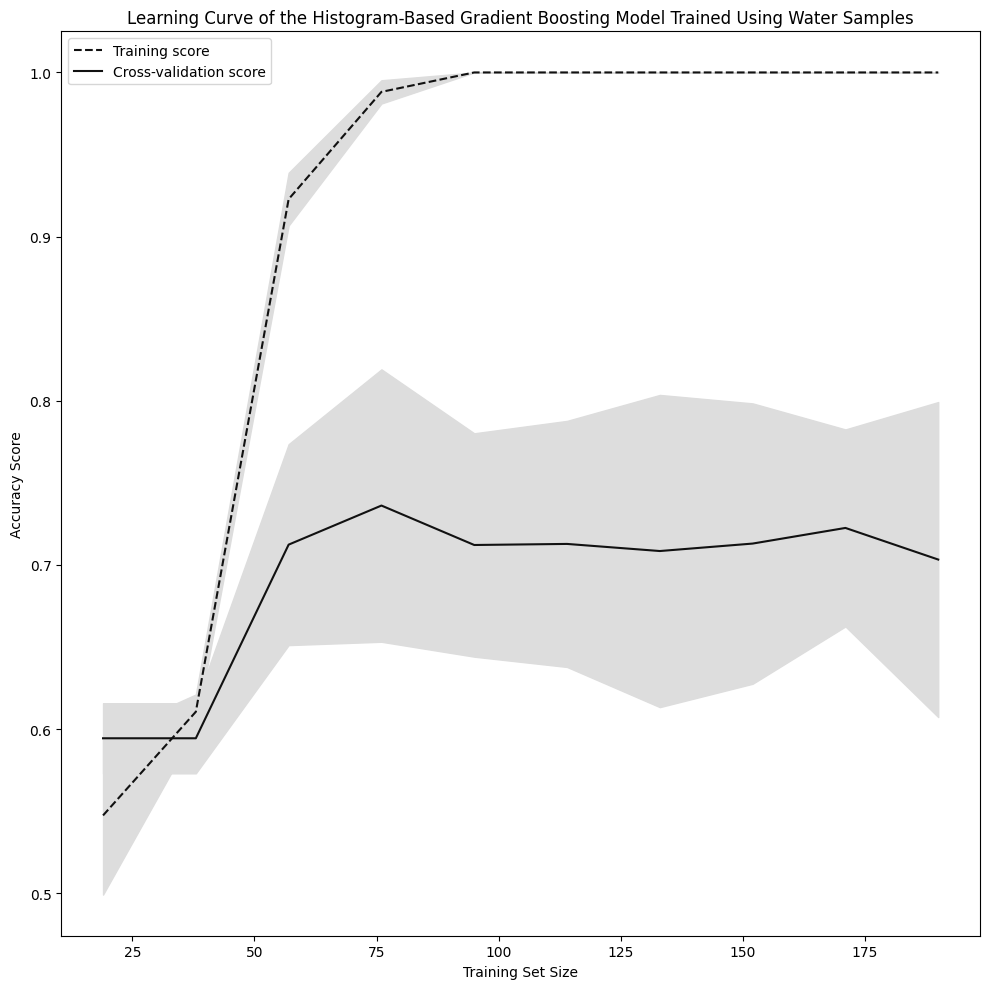

In [14]:
# plot the learning curve 
from matplotlib import pyplot as plt
plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve of the Histogram-Based Gradient Boosting Model Trained Using Water Samples")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.savefig("learningcurveGB_water_baselineV2.jpg") # prelim interpretation: model overfit; maybe tune the model

In [15]:
test_pred = classifier.predict(X_test)

test_pred

array(['sw_2', 'sw_0', 'sw_0', 'sw_0', 'sw_0', 'sw_0', 'sw_2', 'sw_2',
       'sw_2', 'sw_2', 'sw_2', 'sw_0', 'sw_0', 'sw_2', 'sw_0', 'sw_0',
       'sw_0', 'sw_0', 'sw_0', 'sw_0', 'sw_0', 'sw_0', 'sw_0', 'sw_0',
       'sw_1', 'sw_2', 'sw_2', 'sw_0', 'sw_0', 'sw_0', 'sw_0', 'sw_2',
       'sw_0', 'sw_0', 'sw_1', 'sw_2', 'sw_0', 'sw_2', 'sw_2', 'sw_0',
       'sw_0', 'sw_1', 'sw_2', 'sw_2', 'sw_1', 'sw_2', 'sw_0', 'sw_1',
       'sw_2', 'sw_2', 'sw_0', 'sw_0', 'sw_2'], dtype=object)

In [16]:
# get the accuracy score and confusion matrix from the test set. 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy_score(y_test, test_pred)

0.6981132075471698

In [17]:
print(f"RF train accuracy: {gb_fitted.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {gb_fitted.score(X_test, y_test):.3f}")

RF train accuracy: 1.000
RF test accuracy: 0.698


In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import pandas as pd
report = classification_report(y_test, test_pred, output_dict=True)
report2 = classification_report(y_test, test_pred)
print(report2) 

# export the csv file 
df = pd.DataFrame(report).transpose()
df.to_csv('classreportGB_water_baselineV2.csv')

              precision    recall  f1-score   support

        sw_0       0.69      0.95      0.80        21
        sw_1       0.60      0.27      0.37        11
        sw_2       0.74      0.67      0.70        21

    accuracy                           0.70        53
   macro avg       0.68      0.63      0.62        53
weighted avg       0.69      0.70      0.67        53



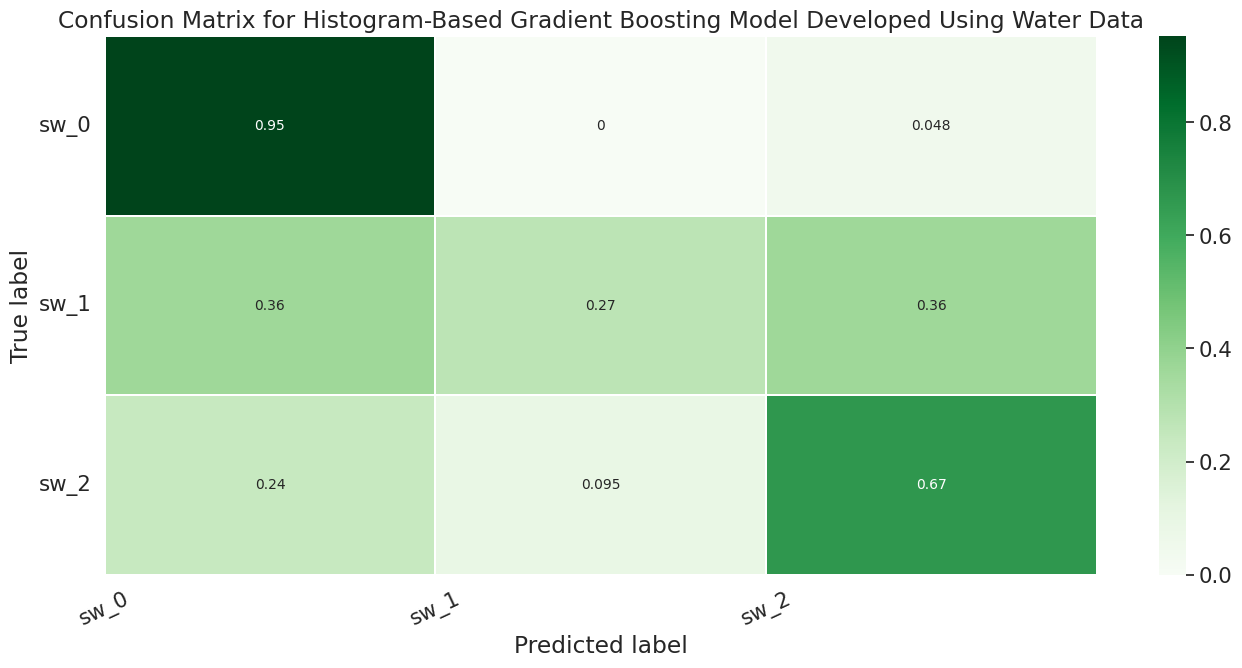

In [19]:
import seaborn as sns
matrix = confusion_matrix(y_test, test_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['sw_0', 'sw_1', 'sw_2']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Histogram-Based Gradient Boosting Model Developed Using Water Data')
#plt.show() 
plt.savefig("confusionmatrixGB_water_baselineV2.jpg", dpi=500, bbox_inches='tight')

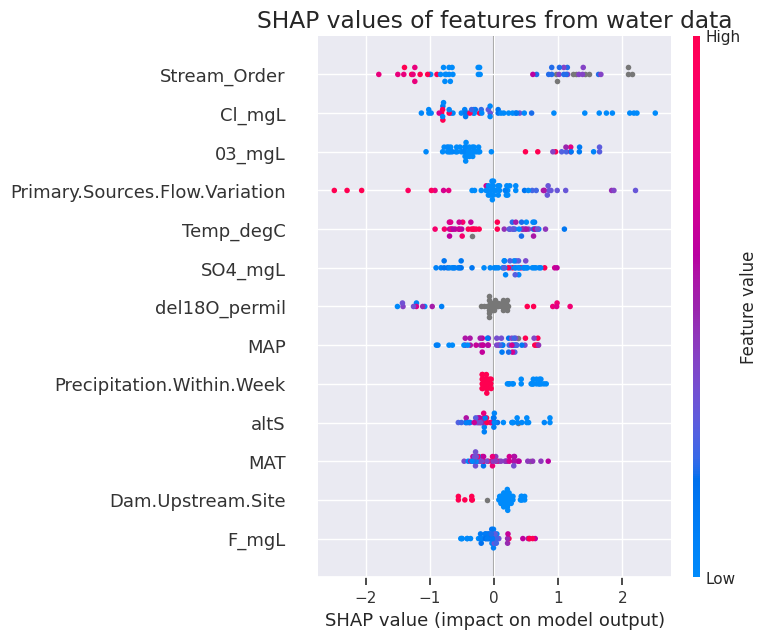

In [20]:
# Plot shap values on TEST data 

import matplotlib.pyplot as plt
# Ref: https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137
explainer = shap.TreeExplainer(gb_fitted)
shap_values = explainer.shap_values(X_test)
# generate a beeswarm plot 
plt.title('SHAP values of features from water data')
shap_1 = shap.summary_plot(shap_values[1], X_test, show=False)
plt.savefig("SHAP_water_baseline_testV2.jpg", dpi=500, bbox_inches='tight') # only can save in png
 
# prelim interpretation: 
# 1. Top 12 features have the highest variation

In [21]:
# Export FORCE PLOT on TEST data 
shap.initjs() # necessary to get the interactive graph 
expected_value = explainer.expected_value # expected value arg is necessary for force plot
f=shap.force_plot(explainer.expected_value[1], shap_values[1], X_test)
shap.save_html("shap_forceplot_water_baseline_testV2.htm", f)

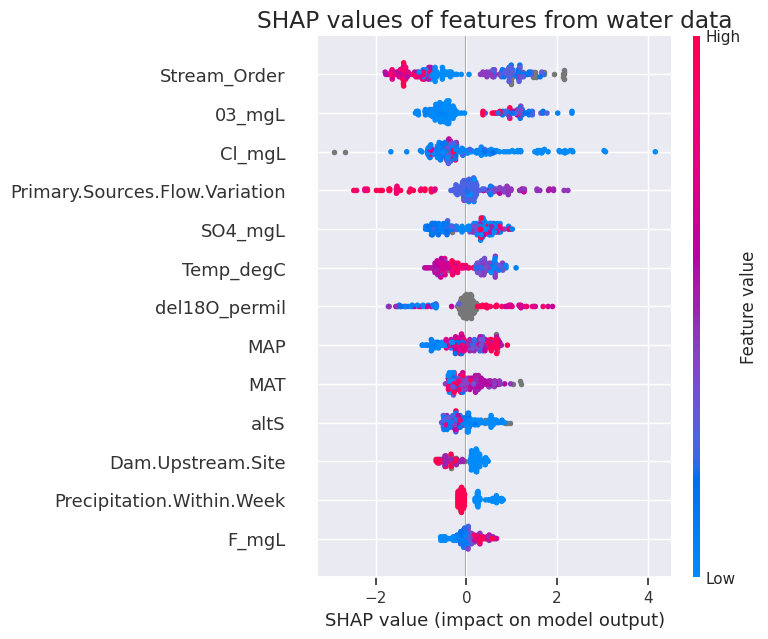

In [22]:
# Plot shapefile values on TRAINING data 

import matplotlib.pyplot as plt
# Ref: https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137
explainer = shap.TreeExplainer(gb_fitted)
shap_values = explainer.shap_values(X_train)
# generate a beeswarm plot 
plt.title('SHAP values of features from water data')
shap_1 = shap.summary_plot(shap_values[1], X_train, show=False)
plt.savefig("SHAP_water_baseline_trainV2.jpg", dpi=500, bbox_inches='tight') # only can save in png

In [23]:
# Export FORCE PLOT on TRAIN data 
shap.initjs() # necessary to get the interactive graph 
expected_value = explainer.expected_value # expected value arg is necessary for force plot
f=shap.force_plot(explainer.expected_value[1], shap_values[1], X_train)
shap.save_html("shap_forceplot_water_baseline_trainV2.htm", f)

# 2. Tuned model development 
Run the analysis both on train and test data.

In [24]:
# example of bayesian optimization with scikit-optimize
from numpy import mean
from sklearn.model_selection import cross_val_score
from skopt.space import Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

In [25]:
# build the pipeline 
from sklearn.pipeline import Pipeline
pipe = Pipeline([('model', HistGradientBoostingClassifier())])

In [26]:
hyperparameter_grid = {
   'learning_rate': [0.005, 0.01, 0.02, 0.04, 0.06, 0.08, 0.9, 0.10, 0.11, 0.115, 0.12], # default 0.1 
    #'max_depth': [8000, 9000, 10000, 50000, 60000, 70000, 80000, 90000, 100000, None], # default None 
    'min_samples_leaf': [10, 15, 20, 23, 24, 25, 26, 27, 30, 35, 40, 45], # default 20
    'max_leaf_nodes':[10, 15,18, 19, 20, 21, 22, 25, 30, 31, 35, 40, 45], # default 31
    'max_iter': [50, 100, 130, 135, 140, 145, 150, 155, 160, 200, 250, 300], # default 100
    'l2_regularization': [0, 0.1, 0.2, 0.001, 0.002, 0.003, 0.0001], # default 0.0
    'early_stopping':['auto', 'True'], 
    'n_iter_no_change': [2,4,6,8,10,12,14] 
}

# Note: max_depth tuning is omitted because the value went up to 100k. I suspect its None (default setting). 

In [27]:
from skopt import BayesSearchCV
opt = BayesSearchCV(classifier, hyperparameter_grid, n_iter=10, return_train_score=True, cv=10, random_state=42)

In [28]:
with joblib.parallel_backend('dask'):
    opt.fit(X_train, y_train)

In [29]:
print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

val. score: 0.7268398268398268
test score: 0.6981132075471698


In [30]:
import pandas as pd

def report(results, n_top=3):
  res = pd.DataFrame(results)
  res = res.sort_values(by=['mean_test_score'], ascending=False, axis=0)
  res.reset_index(inplace = True, drop=True)

  for candidate in range(0, n_top):
    print("Model with rank: {0}".format(candidate))
    print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
          res['mean_test_score'][candidate],
          res['std_test_score'][candidate]))
    print("Parameters: {0}".format(res['params'][candidate]))
    print("") 

In [31]:
report(opt.cv_results_)

Model with rank: 0
Mean validation score: 0.727 (std: 0.071)
Parameters: OrderedDict([('early_stopping', 'auto'), ('l2_regularization', 0.2), ('learning_rate', 0.02), ('max_iter', 130), ('max_leaf_nodes', 35), ('min_samples_leaf', 24), ('n_iter_no_change', 8)])

Model with rank: 1
Mean validation score: 0.727 (std: 0.065)
Parameters: OrderedDict([('early_stopping', 'True'), ('l2_regularization', 0.003), ('learning_rate', 0.12), ('max_iter', 135), ('max_leaf_nodes', 30), ('min_samples_leaf', 25), ('n_iter_no_change', 6)])

Model with rank: 2
Mean validation score: 0.726 (std: 0.078)
Parameters: OrderedDict([('early_stopping', 'True'), ('l2_regularization', 0.2), ('learning_rate', 0.01), ('max_iter', 145), ('max_leaf_nodes', 18), ('min_samples_leaf', 25), ('n_iter_no_change', 4)])



In [58]:
# plug in the best hp values from BayesSearchCV 

classifier_tune = HistGradientBoostingClassifier(
    l2_regularization= 0.2,
    learning_rate=0.02,
    #max_depth=100000, 
    max_iter=130,
    max_leaf_nodes=35,
    min_samples_leaf=24,
    early_stopping='auto',
    n_iter_no_change=8) 

# this is to get the CV scores 
scores = cross_val_score(estimator=classifier_tune, X=X_train, y=y_train, cv=10, n_jobs=-1)

# fit the model using selected HPs 
# only fit if satisfied with the CV scores 
gb_tuned = classifier_tune.fit(X_train, y_train) 

print("training time taken: ", round(time.time() - start, 0), "seconds") 
print("CV accuracy scores: %s" % scores) 
print("CV accuracy:%.3f +/- %.3f" % (np.mean(scores), np.std(scores)))

training time taken:  3401.0 seconds
CV accuracy scores: [0.63636364 0.72727273 0.71428571 0.71428571 0.85714286 0.76190476
 0.66666667 0.80952381 0.76190476 0.61904762]
CV accuracy:0.727 +/- 0.071


In [59]:
# this is to get the LC scores 
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(estimator=classifier_tune, 
                                                        X=X_train, y=y_train, cv=10, n_jobs=-1, random_state=42,
                                                        scoring='accuracy', train_sizes=np.linspace(0.1, 1, 10))

In [60]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

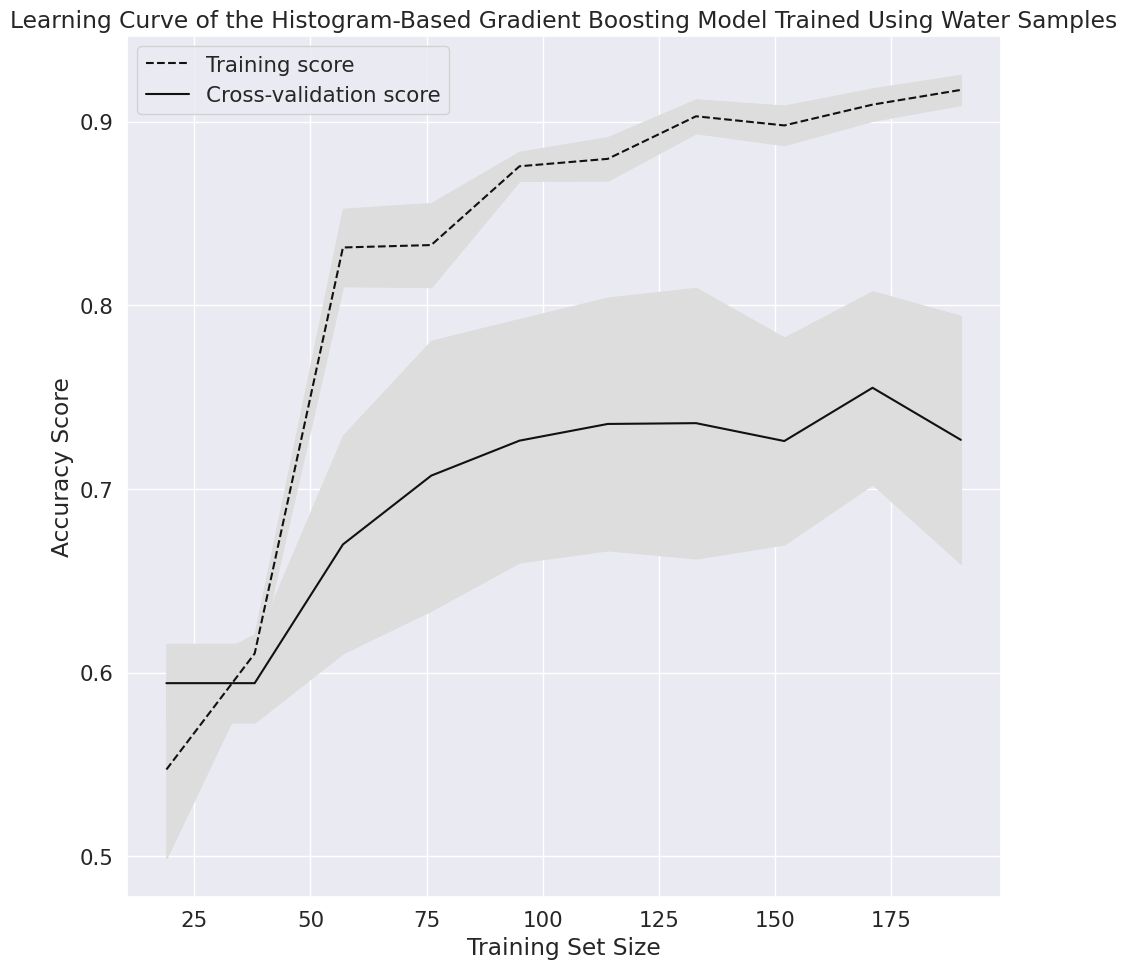

In [61]:
# plot the learning curve
from matplotlib import pyplot as plt
plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve of the Histogram-Based Gradient Boosting Model Trained Using Water Samples")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.savefig("learningcurveGB_water_tunedV2.jpg")

In [62]:
# predict test dataset using the tuned dataset 
test_pred = gb_tuned.predict(X_test)
test_pred

#get the accuracy score and confusion matrix from the test set.
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy_score(y_test, test_pred)

0.6981132075471698

In [63]:
print(f"RF train accuracy: {gb_tuned.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {gb_tuned.score(X_test, y_test):.3f}")

RF train accuracy: 0.910
RF test accuracy: 0.698


In [64]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import pandas as pd
report = classification_report(y_test, test_pred, output_dict=True)
report2 = classification_report(y_test, test_pred)
print(report2) 

# export the csv file 
df = pd.DataFrame(report).transpose()
df.to_csv('classreportGB_water_tunedV2.csv') 

              precision    recall  f1-score   support

        sw_0       0.74      0.95      0.83        21
        sw_1       0.60      0.27      0.37        11
        sw_2       0.67      0.67      0.67        21

    accuracy                           0.70        53
   macro avg       0.67      0.63      0.62        53
weighted avg       0.68      0.70      0.67        53



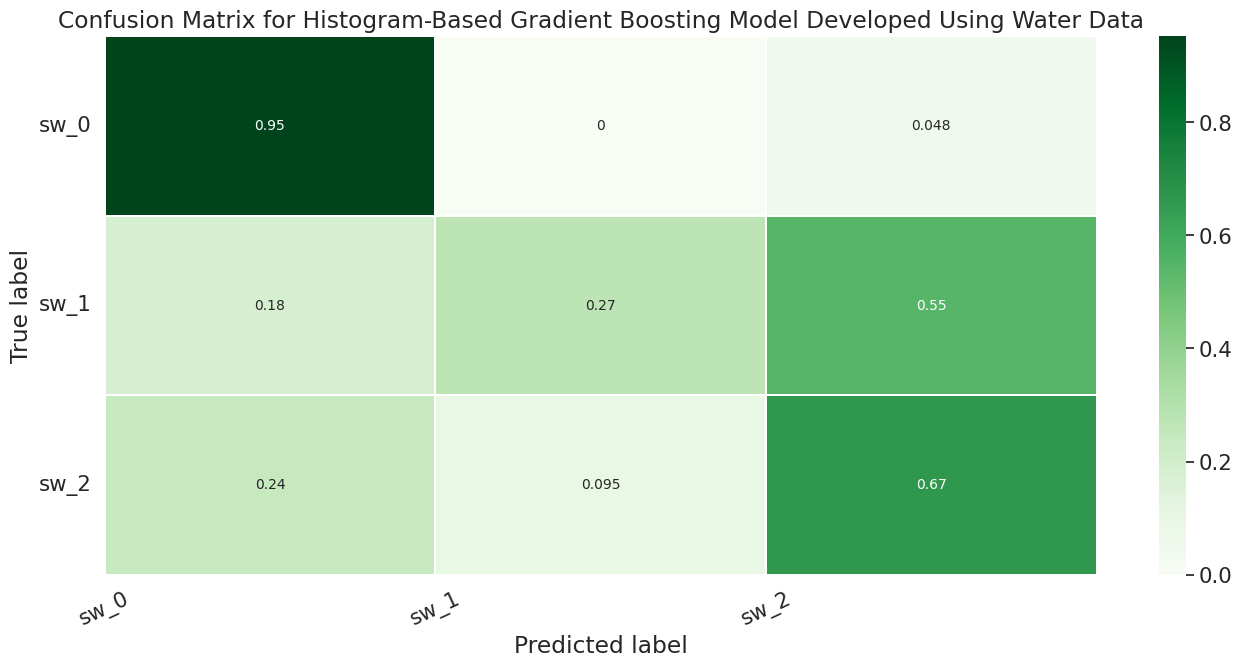

In [65]:
import seaborn as sns
matrix = confusion_matrix(y_test, test_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['sw_0', 'sw_1', 'sw_2']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Histogram-Based Gradient Boosting Model Developed Using Water Data')
#plt.show() 
plt.savefig("confusionmatrixGB_water_tunedV2.jpg", dpi=500, bbox_inches='tight')

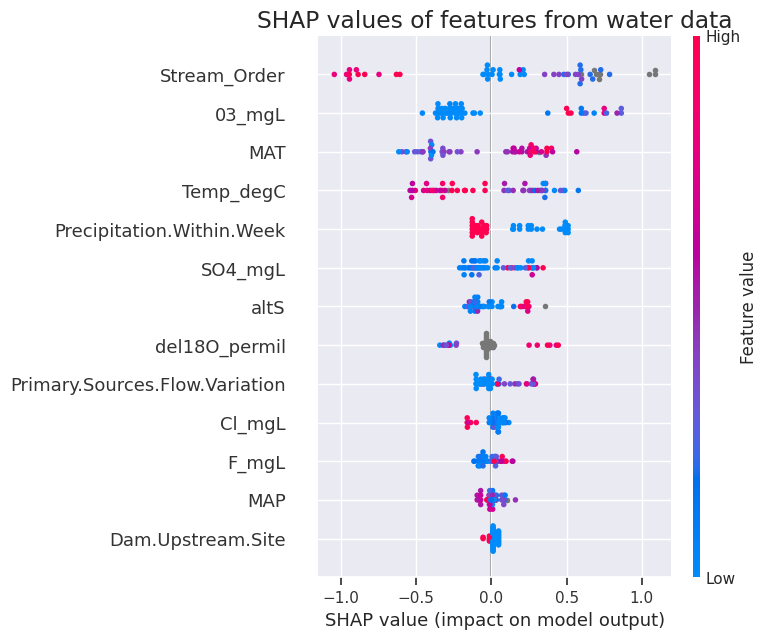

In [66]:
# Plot shap values on TEST data 

import matplotlib.pyplot as plt
# Ref: https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137
explainer = shap.TreeExplainer(gb_tuned)
shap_values = explainer.shap_values(X_test)
# generate a beeswarm plot 
plt.title('SHAP values of features from water data')
shap_1 = shap.summary_plot(shap_values[1], X_test, show=False)
plt.savefig("SHAP_water_tuned_testV2.jpg", dpi=500, bbox_inches='tight') # only can save in png
 
# prelim interpretation: 
# 1. Top 12 features have the highest variation

In [67]:
# Export FORCE PLOT on TEST data 
shap.initjs() # necessary to get the interactive graph 
expected_value = explainer.expected_value # expected value arg is necessary for force plot
f=shap.force_plot(explainer.expected_value[1], shap_values[1], X_test)
shap.save_html("shap_forceplot_water_tuned_testV2.htm", f)

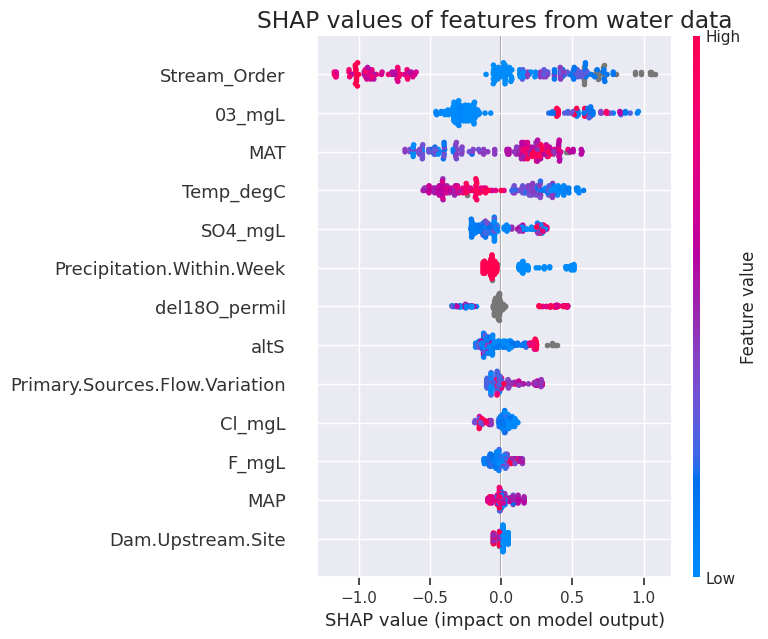

In [68]:
# Plot shapefile values on TRAINING data 

import matplotlib.pyplot as plt
# Ref: https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137
explainer = shap.TreeExplainer(gb_tuned)
shap_values = explainer.shap_values(X_train)
# generate a beeswarm plot 
plt.title('SHAP values of features from water data')
shap_1 = shap.summary_plot(shap_values[1], X_train, show=False)
plt.savefig("SHAP_water_tuned_trainV2.jpg", dpi=500, bbox_inches='tight') # only can save in png

In [69]:
# Export FORCE PLOT on TRAIN data 
shap.initjs() # necessary to get the interactive graph 
expected_value = explainer.expected_value # expected value arg is necessary for force plot
f=shap.force_plot(explainer.expected_value[1], shap_values[1], X_train)
shap.save_html("shap_forceplot_water_tuned_trainV2.htm", f)

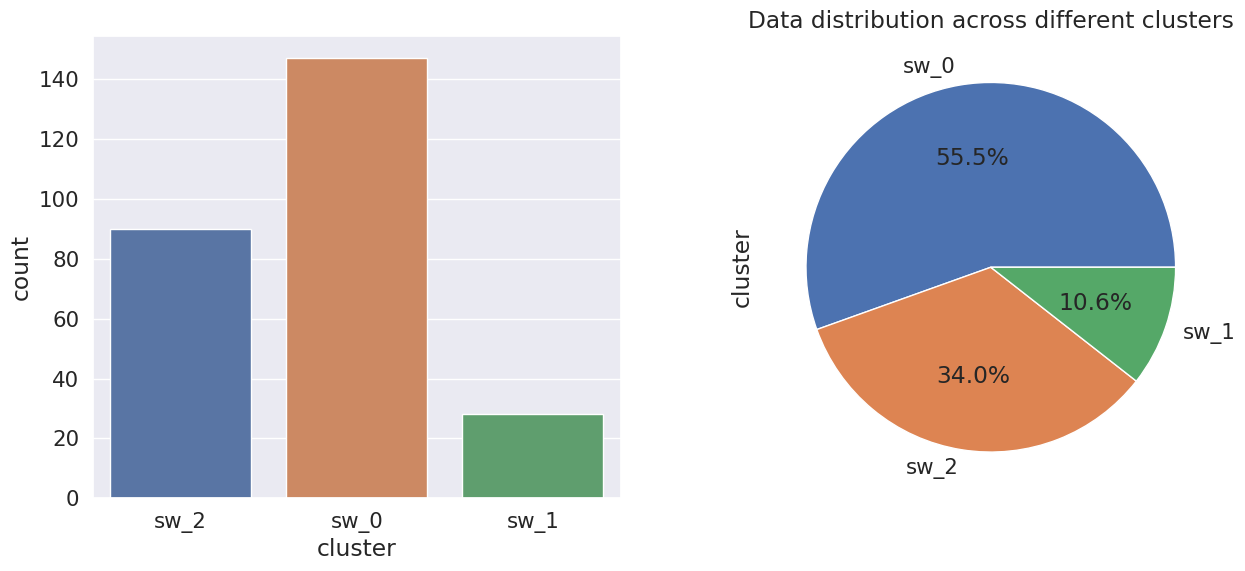

In [70]:
# Lastly print the data distribution accross classes 
import seaborn as sns


fig, ax=plt.subplots(1,2,figsize=(15,6))
plt.title('Data distribution across different clusters')
_ = sns.countplot(x='cluster', data=data, ax=ax[0])
_ = data['cluster'].value_counts().plot.pie(autopct="%1.1f%%", ax=ax[1])

plt.savefig("water_classdistibutionV2.jpg", dpi=500, bbox_inches='tight')

# ** End of notebook **¶
The cells following this are for trial purposes

# Bayesian Optimisation - method 2 
# using Hyperopt implementation

# define the search space. 
# use the same as hp grid 
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval
from sklearn.model_selection import StratifiedKFold
# Space
space = {
    'learning_rate': hp.choice('learning_rate', [0.005, 0.01, 0.02, 0.04, 0.06, 0.08, 0.9, 0.10, 0.11, 0.12]),
    'max_depth' : hp.choice('max_depth', [75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 90, 95, 100, 105, 110, 115, 120]),
    'min_samples_leaf' : hp.choice('min_samples_leaf', [10, 15, 20, 23, 24, 25, 26, 27, 30, 35, 40, 45]),
    'max_leaf_nodes' : hp.choice('max_leaf_nodes', [10, 15,18, 19, 20, 21, 22, 25, 30, 31, 35, 40, 45]),     
    'max_iter' : hp.choice('max_iter', [50, 100, 130, 135, 140, 145, 150, 155, 160, 200, 250, 300]), 
    'l2_regularization' : hp.choice('l2_regularization', [0, 0.1, 0.2, 0.001, 0.002, 0.003, 0.0001])
}

# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# Objective function
def objective(params):
    
    gb_tune = HistGradientBoostingClassifier(**params)
    scores = cross_val_score(gb_tune, X_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1)
    # Extract the best score
    best_score = max(scores)
    # Loss must be minimized
    accuracy = best_score
    # Dictionary with information for evaluation
    return {'accuracy': accuracy, 'params': params, 'status': STATUS_OK}
# Trials to track progress
bayes_trials = Trials()
# Optimize
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 48, trials = bayes_trials)

# Print the index of the best parameters
print(best)
# Print the values of the best parameters
print(space_eval(space, best))

# Train model using the best parameters
gb_tune = XGBClassifier(seed=0, 
                           colsample_bytree=0.4, 
                           gamma=0.2, 
                           learning_rate=1, 
                           max_depth=12, 
                           reg_alpha=1e-05,
                           reg_lambda=1
                           ).fit(X_train_transformed,y_train)
# Make prediction using the best model
bayesian_opt_predict = xgboost_bo.predict(X_test_transformed)
# Get predicted probabilities
bayesian_opt_predict_prob = xgboost_bo.predict_proba(X_test_transformed)[:,1]
# Get performance metrics
precision, recall, fscore, support = score(y_test, bayesian_opt_predict)
# Print result
print(f'The recall value for the xgboost Bayesian optimization is {recall[1]:.4f}')

# get the accuracy score and confusion matrix from the test set. 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy_score(y_test, test_pred)

import numpy as np

# Function mapping hyperparameters to a real-valued score
def objective(hyperparameters):
    
    # Machine learning model
    gb = HistGradientBoostingClassifier(**hyperparameters)
    
    # Training 
    # This is very expensive to compute, use dask
    with joblib.parallel_backend('dask'):
        gb_fitted = gb.fit(X_train, y_train)
    
    # Making predictions and evaluating
    predictions = gb.predict(X_train)
    rmse = np.sqrt(np.mean(np.square(predictions - y_valid)))
    
    return rmse

best_accuracy_hgb = gb_fitted.score

print("Best Accuracy of HGB: ", best_accuracy_hgb)  
#print("Best Parameter of HGB:", best_parameter_hgb) 
print("training time taken: ", round(time.time() - start, 0), "seconds")

# define the function used to evaluate a given configuration
@use_named_args(search_space)
def evaluate_model(**params):
	# something
	classifier.set_params(**params)
	# calculate 5-fold cross validation
	result = cross_val_score(classifier, X_train, y_train, cv=5, n_jobs=-1, scoring='accuracy')
	# calculate the mean of the scores
	estimate = mean(result)
	return 1.0 - estimate
 
# perform optimization
with joblib.parallel_backend('dask'):
    result = gp_minimize(evaluate_model, search_space)
# summarizing finding:
print('Best Accuracy: %.3f' % (1.0 - result.fun))
print('Best Parameters: n_neighbors=%d, p=%d' % (result.x[0], result.x[1]))

from sklearn.model_selection import RandomizedSearchCV

start = time.time()

parameters_hgb = [{'max_iter': [1000,1200,1600], 
                   'learning_rate': [0.1, 0.2, 0.3], 
                   'max_depth' : [25, 50, 75], 
                   'l2_regularization': [1.5]}] 
grid_search_hgb = RandomizedSearchCV(estimator = classifier, param_distributions=parameters_hgb, 
                               scoring = 'accuracy', cv = 10, n_jobs = 1, verbose=10) # always include verbose param (in +ve integer) to monitor progress
                                # and n_jobs must be a positive number (=1)

    # grid search using dask, import joblib first   
with joblib.parallel_backend('dask'): 
    gb_fitted_tuned = grid_search_hgb.fit(X_train, y_train) 
best_accuracy_hgb = gb_fitted_tuned.best_score_ 
best_parameter_hgb = gb_fitted_tuned.best_params_

print("Best Accuracy of HGB: {:.2f} %".format(best_accuracy_hgb.mean()*100)) 
print("Best Parameter of HGB:", best_parameter_hgb)
print("training time taken: ", round(time.time() - start, 0), "seconds")

cv_df = pd.DataFrame(grid_search_hgb.cv_results_).head() 
df.to_csv('tuning_result_sed_tuned.csv')

# fit the tuned parameters 

start = time.time()
#classifier = RandomForestClassifier()
classifier = HistGradientBoostingClassifier(max_iter= 1000, max_depth= 50, learning_rate=0.1, l2_regularization= 1.5) # this can handle NaNs

#rf_fitted = classifier.fit(X_train, y_train)
gb_tuned = classifier.fit(X_train, y_train) 

scores = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=10, n_jobs=-1)

print("training time taken: ", round(time.time() - start, 0), "seconds")
print("CV accuracy scores: %s" % scores)
print("CV accuracy:%.3f +/- %.3f" % (np.mean(scores), np.std(scores))) 

# learning curve for tuned model 
train_sizes, train_scores, test_scores = learning_curve(estimator=gb_tuned, 
                                                        X=X_train, y=y_train, cv=10, n_jobs=-1, 
                                                        scoring='accuracy', train_sizes=np.linspace(0.1, 1, 10))

# get data to plot the learning curve 
from sklearn.model_selection import learning_curve

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# plot the learning curve 
from matplotlib import pyplot as plt
plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve of the Tuned Histogram-based Gradient Boosting Classification Tree Model Trained Using Sediment Samples")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.savefig("learningcurveGB_sed_tuned.jpg") # prelim interpretation: model overfit; maybe tune the model

Notes: 1. Should you run SHAP on test or train data? Ans: Either one, depending on what do you want to know [1] // 2. Can HGB handle different data types? Ans: Yes, all tree-based model can handle different dtypes [2] 

[1] https://datascience.stackexchange.com/questions/61395/shap-value-analysis-gives-different-feature-importance-on-train-and-test-set 
[2] https://www.quora.com/Decision-Tree-based-models-dont-require-scaling-How-does-scaling-impact-the-predictions-of-decision-tree-based-models 